In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style()
import pickle

import pandas_profiling
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() 

from sklearn.model_selection import TimeSeriesSplit

DATA_PATH = '/home/users/ucadatalab_group/davidgg/SHARED/SOLAR/data'
# We load the final df, normalized with clearsky, 16 sensors
with open(os.path.join(DATA_PATH,'oahu_min_final.pkl'),'rb') as file:
    df = pickle.load(file)

In [4]:
sys.path.insert(0,'/'.join(os.getcwd().split('/')[:-1]+['src']))
from utils.df_to_roll import df_to_roll
from utils.df_to_roll import to_array_cov1d,to_array_cov2d

In [7]:
# We load the info of the sensors to extract the longitude information
info = pd.read_csv(os.path.join(DATA_PATH,'info.csv'))

info.Location = info.Location.apply(lambda x: (x[:2] + x[-2:]).replace('_', ''))
info.index = info.Location
# Sorted longitudes
longs = info['Longitude'].sort_values(ascending=False)
# There is no AP3 in this book
longs.drop('AP3',inplace=True)
# Sort df sensors by longitude
df = df[longs.index]

In [8]:
pandas_profiling.ProfileReport(df,bins=20,correlation_threshold=0.95)

Number of variables,17
Number of observations,355387
Total Missing (%),0.0%
Total size in memory,46.1 MiB
Average record size in memory,136.0 B
Numeric,16
Categorical,0
Boolean,0
Date,0
Text (Unique),1
Rejected,0


## Looking for zeros

At day 2011-10-31 there was problems with AP7 and AP1. This day corresponds to the TEST set.

In [6]:
# This is also the only day where there are extreme values val > 2
df[(df > 2).any(axis=1)]

Location,AP7,AP6,AP4,AP5,AP1,DH5,DH3,DH4,DH11,DH2,DH10,DH8,DH6,DH7,DH9,DH1
Datetime,,,,,,,,,,,,,,,,
2011-10-31 17:22:00-10:00,2.065985,0.105983,0.115188,0.109622,0.0,0.119818,0.104883,0.115129,0.105974,0.118501,0.113605,0.106436,0.115775,0.122656,0.101939,0.126156
2011-10-31 17:23:00-10:00,2.153433,0.111720,0.122369,0.116740,0.0,0.128256,0.109314,0.122519,0.114173,0.126938,0.121885,0.112191,0.123138,0.130294,0.109279,0.133790
2011-10-31 17:24:00-10:00,2.250705,0.115450,0.123067,0.116813,0.0,0.128160,0.111068,0.122762,0.112833,0.125489,0.120099,0.110658,0.122172,0.131026,0.107859,0.134998
2011-10-31 17:25:00-10:00,2.359431,0.111395,0.116359,0.111563,0.0,0.118318,0.103117,0.113459,0.106036,0.116506,0.113171,0.104942,0.114427,0.121182,0.099756,0.125079
2011-10-31 17:26:00-10:00,2.481605,0.105586,0.109078,0.105882,0.0,0.112768,0.097951,0.107680,0.100076,0.110668,0.106982,0.098743,0.107441,0.114697,0.094417,0.119581
2011-10-31 17:27:00-10:00,2.619685,0.099241,0.103909,0.099680,0.0,0.108085,0.092311,0.102907,0.095067,0.107078,0.101627,0.093491,0.102816,0.110600,0.090428,0.114998
2011-10-31 17:28:00-10:00,2.776729,0.095475,0.104180,0.099241,0.0,0.110202,0.093919,0.104178,0.095953,0.107587,0.103216,0.094206,0.104154,0.110877,0.089967,0.115928
2011-10-31 17:29:00-10:00,2.956582,0.098206,0.104583,0.102249,0.0,0.112693,0.095822,0.107444,0.098746,0.111401,0.106698,0.096830,0.107471,0.114666,0.093694,0.120251
2011-10-31 17:30:00-10:00,3.164131,0.101406,0.103440,0.102118,0.0,0.109024,0.093616,0.105695,0.098371,0.107450,0.103943,0.098054,0.107700,0.111866,0.093568,0.118510


In [231]:
dates_with_zeros = df[(df == 0).sum(axis=1)!=0].index
df[(df == 0).sum(axis=1)!=0]

Location,AP7,AP6,AP4,AP5,AP1,DH5,DH3,DH4,DH11,DH2,DH10,DH8,DH6,DH7,DH9,DH1
Datetime,,,,,,,,,,,,,,,,
2011-10-31 14:57:00-10:00,0.730146,0.222799,0.303491,0.199010,0.0,0.215793,0.197924,0.207120,0.195953,0.222458,0.206958,0.197835,0.213093,0.218725,0.200003,0.235378
2011-10-31 14:58:00-10:00,0.730983,0.240965,0.210922,0.195017,0.0,0.220245,0.182671,0.224530,0.182255,0.241759,0.191409,0.181770,0.189771,0.202259,0.179073,0.246627
2011-10-31 14:59:00-10:00,0.731833,0.277964,0.300267,0.199470,0.0,0.193702,0.176684,0.184388,0.182467,0.484857,0.192025,0.178547,0.190857,0.305415,0.259879,0.351331
2011-10-31 15:00:00-10:00,0.732695,0.219297,0.684157,0.202666,0.0,0.192396,0.177926,0.185465,0.186065,0.572306,0.186316,0.182195,0.193652,0.310382,0.187766,0.724320
2011-10-31 15:01:00-10:00,0.733570,0.202010,0.625959,0.199096,0.0,0.182649,0.171924,0.177501,0.179512,0.193857,0.180199,0.176388,0.183730,0.200460,0.172972,0.678754
2011-10-31 15:02:00-10:00,0.734458,0.203540,0.197745,0.184069,0.0,0.179412,0.170059,0.171246,0.178034,0.177689,0.174070,0.167124,0.173742,0.178450,0.161774,0.192645
2011-10-31 15:03:00-10:00,0.735360,0.368534,0.205087,0.189390,0.0,0.686979,0.671207,0.319159,0.258466,0.177907,0.314819,0.236762,0.181494,0.171523,0.160934,0.172765
2011-10-31 15:04:00-10:00,0.736275,0.673544,0.757395,0.211734,0.0,0.183318,0.170480,0.174264,0.181024,0.558267,0.177279,0.180489,0.247375,0.182682,0.184005,0.614117
2011-10-31 15:05:00-10:00,0.737205,0.584497,0.340428,0.245633,0.0,0.181619,0.173817,0.174916,0.188061,0.435888,0.179094,0.175527,0.175070,0.452647,0.163418,0.691210


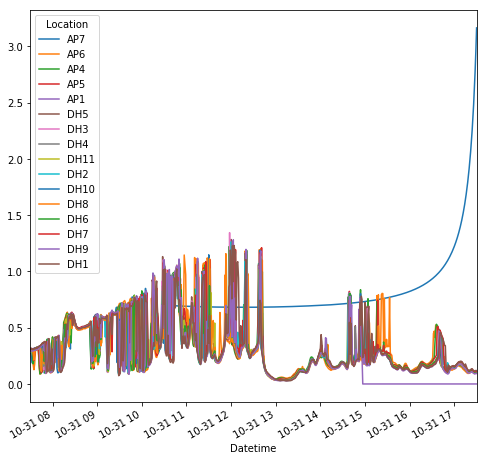

In [258]:
df['2011-10-31'].plot(figsize=(8,8))

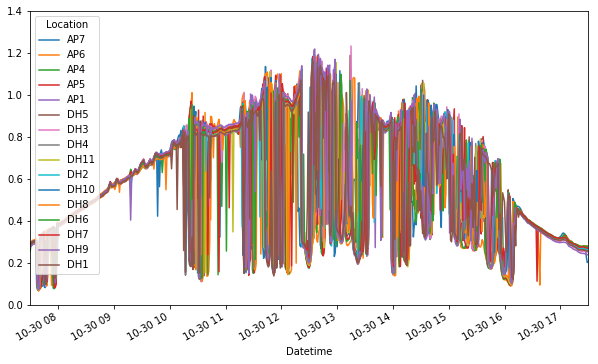

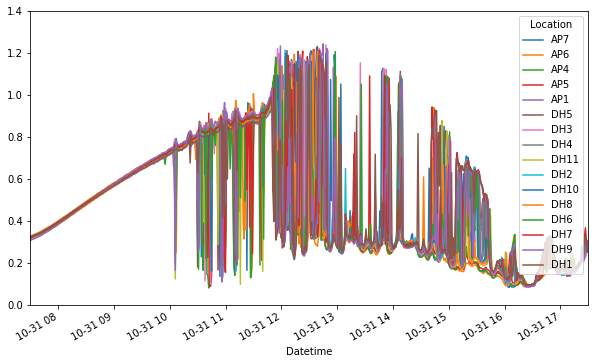

In [269]:
df['2010-10-30'].plot(figsize=(10,6),ylim=(0,1.4))
df['2010-10-31'].plot(figsize=(10,6),ylim=(0,1.4))

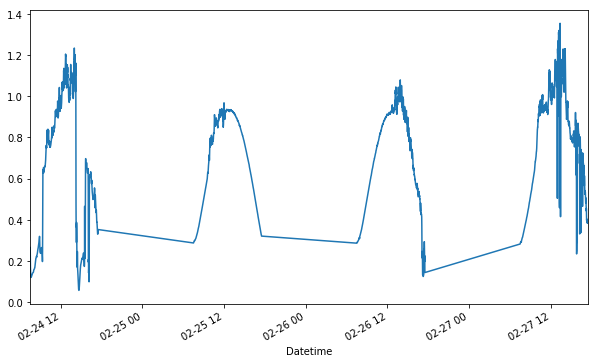

In [287]:
df.loc['2011-02-24':'2011-02-27'].max(axis=1).plot(figsize=(10,6))

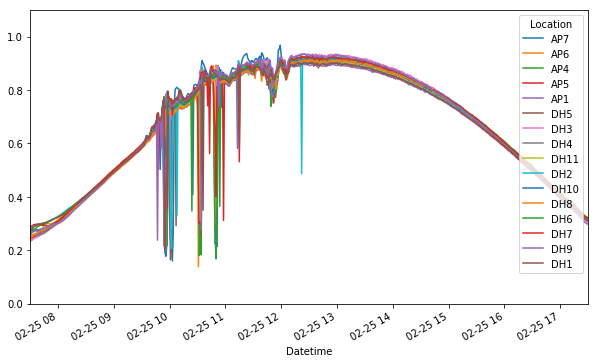

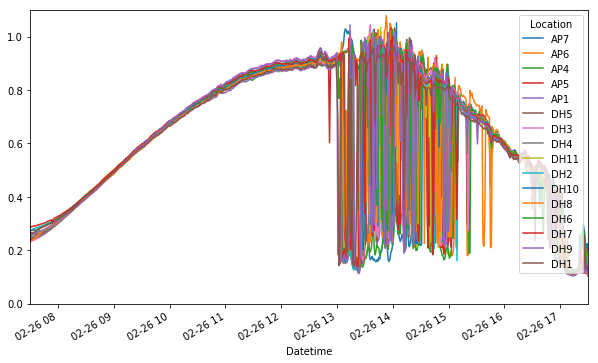

In [273]:
df['2011-02-25'].plot(figsize=(10,6),ylim=(0,1.1))
df['2011-02-26'].plot(figsize=(10,6),ylim=(0,1.1))

In [4]:
df_roll = df_to_roll(df,width=10,step=1)

# Some useful variables
longs_np = longs.index.to_numpy()
n_sensors = len(longs_np)
print('Number of sensors considered:',n_sensors)
times = df_roll.columns.levels[0].tolist()
chosen_times = times[1:10:1]
print('Chosen times slices as features:',chosen_times)
print('Number of time slices considered:',len(chosen_times))

# Split train-test, approximately 12 and 4 months respectively
df_train, df_test = df_roll[:'2011-07-31'], df_roll['2011-08-01':]

Number of sensors considered: 16
Chosen times slices as features: ['t-1', 't-2', 't-3', 't-4', 't-5', 't-6', 't-7', 't-8', 't-9']
Number of time slices considered: 9


## Time  periodicity related features

In [78]:
# Time related features
dates = df_train.index.to_numpy(dtype='datetime64')
hour_of_the_day = (dates - dates.astype('datetime64[D]')).astype(int)/60/60/10**9
day_of_the_year = (dates - dates.astype('datetime64[Y]')).astype(int)/60/60/10**9/24
time_feat_np = np.vstack([np.sin(2*np.pi*hour_of_the_day/24.),np.cos(2*np.pi*hour_of_the_day/24.),
           np.sin(2*np.pi*day_of_the_year/365),np.cos(2*np.pi*day_of_the_year/365)]).T

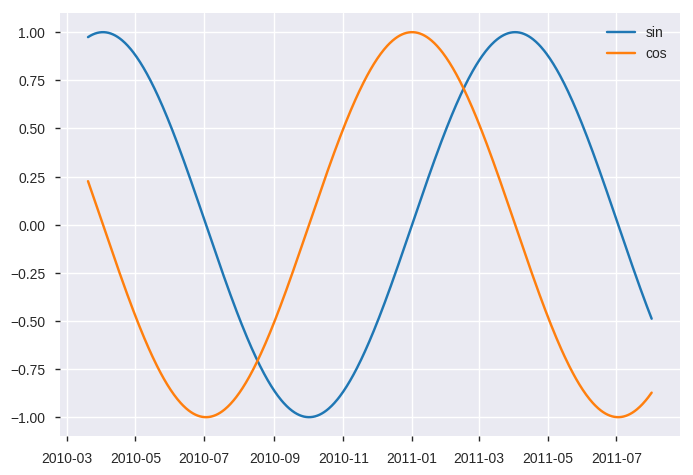

In [99]:
plt.plot(dates,time_feat_np[:,2],label='sin')
plt.plot(dates,time_feat_np[:,3],label='cos')
plt.legend()
plt.show()

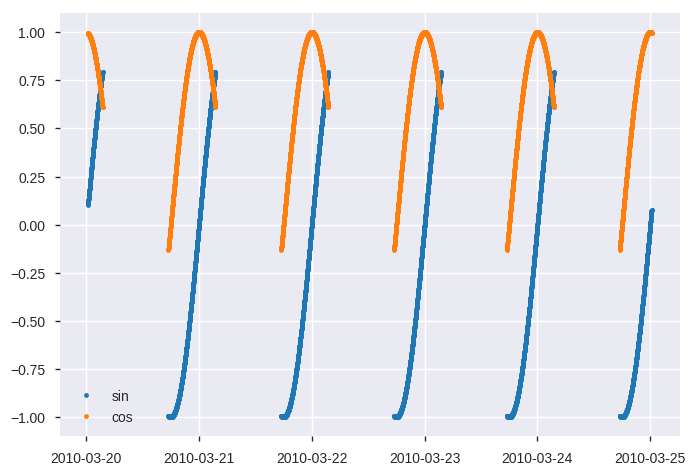

In [111]:
plt.plot_date(dates[:3000],time_feat_np[:3000,0], linestyle='', marker='.',label='sin')
plt.plot_date(dates[:3000],time_feat_np[:3000,1], linestyle='', marker='.',label='cos')
plt.legend()
plt.show()

## Exploration of the K-fold validation split

Mean value (Validation): 0.7009578394539423


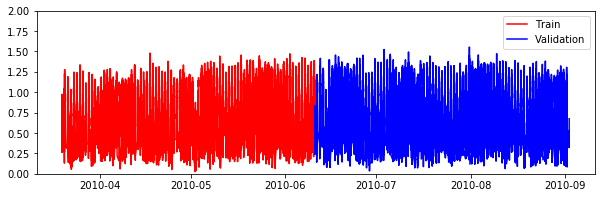

Mean value (Validation): 0.5696878659097668


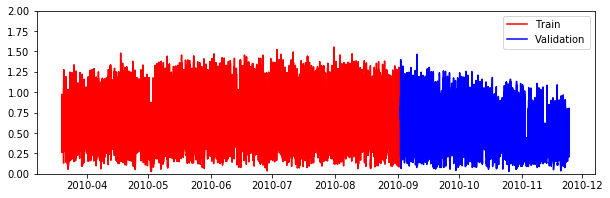

Mean value (Validation): 0.4479689905950863


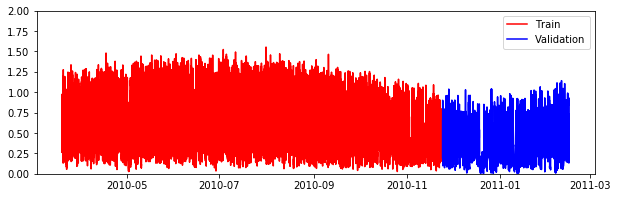

Mean value (Validation): 0.5924560443794082


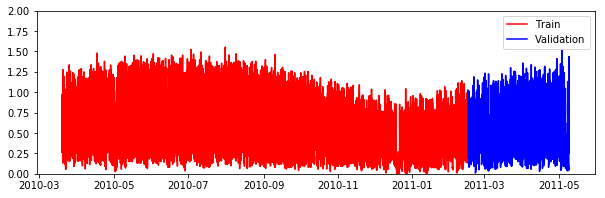

Mean value (Validation): 0.7272238763310943


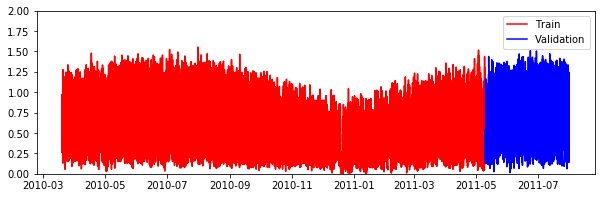

In [288]:
for i,(tr_idx, va_idx) in enumerate(TimeSeriesSplit(n_splits=5).split(X_tr)):
    print('Mean value (Validation):',y_tr[va_idx].mean())
    plt.figure(figsize=(10,3))
    plt.ylim(0,2)
    plt.plot_date(df_train.index.to_numpy()[tr_idx],y_tr[tr_idx].mean(axis=1),c='r',fmt='-',label='Train')
    plt.plot_date(df_train.index.to_numpy()[va_idx],y_tr[va_idx].mean(axis=1),c='b',fmt='-',label='Validation')
    plt.legend()
    plt.show()

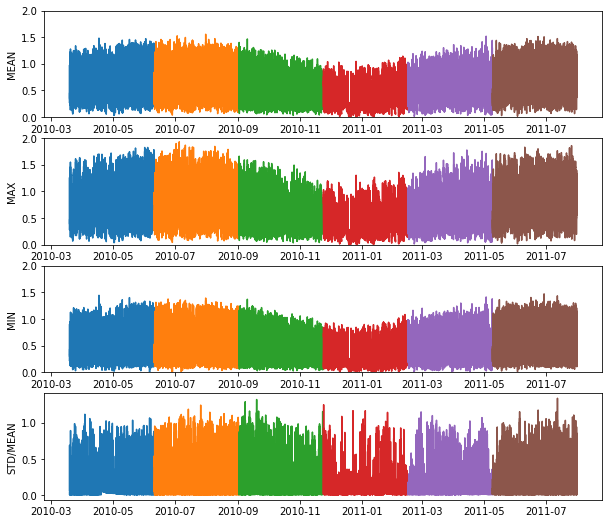

In [289]:
indices_fold = [i*int(len(X_tr)/6) for i in range(0,7,1)]
dates_np = df_train.index.to_numpy()

fig = plt.figure(figsize=(10,9))
plt.title('5-Fold Time Split')
plt.xlabel('Date')


ax0 = plt.subplot2grid((4,1), (0,0), rowspan=1, colspan=1)
for i in range(len(indices_fold)-1):
    indices = np.arange(indices_fold[i],indices_fold[i+1],1)
    plt.plot_date(dates_np[indices],y_tr[indices].mean(axis=1),fmt='-')
plt.ylabel('MEAN')
plt.ylim(0,2)

ax1 = plt.subplot2grid((4,1), (1,0), rowspan=1, colspan=1)
for i in range(len(indices_fold)-1):
    indices = np.arange(indices_fold[i],indices_fold[i+1],1)
    plt.plot_date(dates_np[indices],y_tr[indices].max(axis=1),fmt='-')
plt.ylabel('MAX')
plt.ylim(0,2)

ax2 = plt.subplot2grid((4,1), (2,0), rowspan=1, colspan=1, sharex=ax1)
for i in range(len(indices_fold)-1):
    indices = np.arange(indices_fold[i],indices_fold[i+1],1)
    plt.plot_date(dates_np[indices],y_tr[indices].min(axis=1),fmt='-')
plt.ylabel('MIN')
plt.ylim(0,2)

ax3 = plt.subplot2grid((4,1), (3,0), rowspan=1, colspan=1, sharex=ax1)
for i in range(len(indices_fold)-1):
    indices = np.arange(indices_fold[i],indices_fold[i+1],1)
    plt.plot_date(dates_np[indices],y_tr[indices].std(axis=1)/y_tr[indices].mean(axis=1),fmt='-')
plt.ylabel('STD/MEAN')

plt.show()